In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from matplotlib import cm

In [2]:
import json
import hypernetx as hnx
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import os
import glob
from tqdm.notebook import tqdm

## Load Data

In [3]:
paps = []
for f_name in glob.glob("./data/*.json"):
    with open(f_name, "r") as f:
        dat = json.load(f)
        paps = paps + dat["hits"]["hits"]
print(f"{len(paps)} papers loaded")

3000 papers loaded


In [4]:
def get_authors(pap):
    if "authors" in pap["metadata"].keys():
        return [a["full_name"] for a in pap["metadata"]["authors"]]
    else:
        return []
def get_title(pap):
    return pap["metadata"]["titles"][0]["title"]

def get_type(pap):
    return pap["metadata"]["primary_arxiv_category"]
    
def get_id(pap):
    return pap["id"]

In [5]:
paps_dict = { get_id(p):[a for a in get_authors(p)] for p in paps}

H = hnx.Hypergraph(paps_dict)
H.shape

(23207, 2989)

In [6]:
comp_sizes = [[comp.shape, comp.nodes.items, comp.edges.items] for comp in tqdm(H.s_component_subgraphs())]
print("There are ", len(comp_sizes), " connected components")
sorted_comps = sorted(comp_sizes, key=lambda x: x[0])[::-1]

0it [00:00, ?it/s]

There are  185  connected components


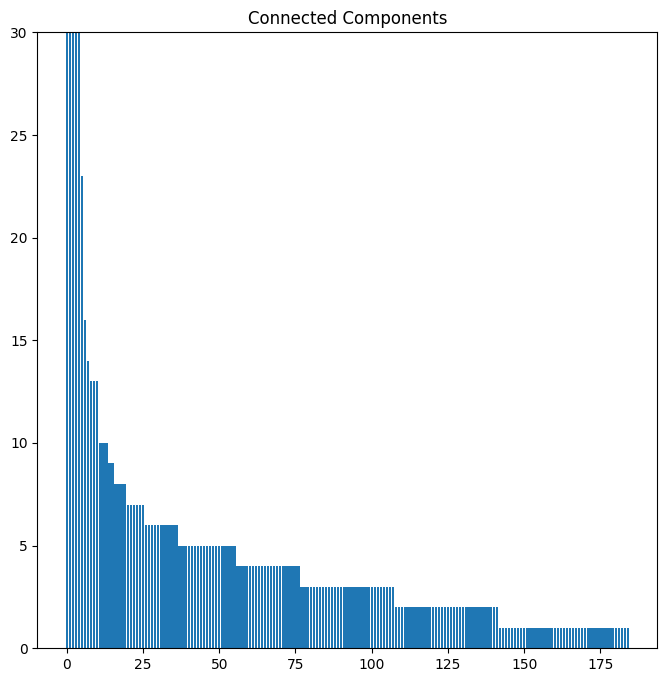

In [7]:
plt.bar(range(len(sorted_comps)), [c[0][0] for c in sorted_comps])
plt.ylim(0, 30)
plt.title("Connected Components")
plt.show()

Here are some plots

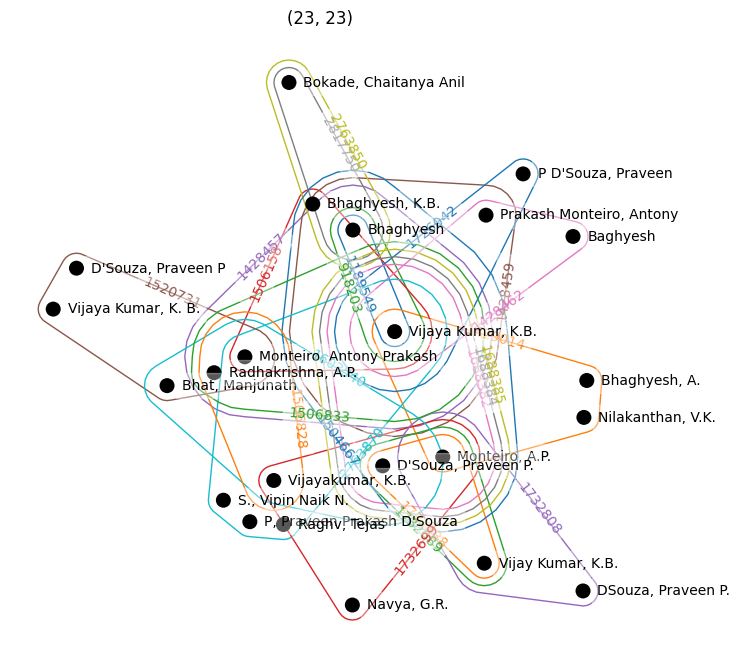

In [8]:
h_small = H.restrict_to_nodes(sorted_comps[5][1])
hnx.draw(h_small)
plt.title(h_small.shape)
plt.show()

## Construct Simplicial Complex

In [10]:
import gudhi as gd

In [11]:
import itertools

def is_valid_simplicial_complex(simplices):
    """
    Checks if a collection of simplices forms a valid abstract simplicial complex.
    A valid abstract simplicial complex must be closed under subsets.
    
    Args:
        simplices (list of tuples or lists): A collection of simplices, where each
                                             simplex is represented by an iterable of vertices.
    
    Returns:
        bool: True if the collection is a valid abstract simplicial complex, False otherwise.
    """
    # Convert all simplices to frozensets for efficient lookups
    complex_set = {frozenset(s) for s in simplices}
    
    # Iterate through each simplex in the collection
    for simplex in complex_set:
        # Generate all proper subsets (faces) of the current simplex
        # The length of the subset ranges from 1 to the dimension of the simplex.
        for i in range(len(simplex)):
            for face in itertools.combinations(simplex, i):
                # Check if each face is present in the collection
                if frozenset(face) not in complex_set:
                    print(f"Validation failed: Face {set(face)} of simplex {set(simplex)} is missing.")
                    return False
    
    # If all checks pass, it is a valid simplicial complex
    return True

### Closure homology

In [12]:
def closure_simplex(h):
    node_dict = {n:i for i, n in enumerate(h.nodes)}
    bp = h.bipartite()
    simplex_tree = gd.SimplexTree()
    for e in h.edges():
         simplex_tree.insert( [node_dict[n] for n in bp.neighbors(e)])    
    return simplex_tree

In [17]:
h_small = H.restrict_to_nodes(sorted_comps[2][1])
h_small.shape

(42, 40)

In [18]:
simplex_tree = closure_simplex(h_small)
persistence = simplex_tree.persistence()
persistence

[(1, (0.0, inf)), (1, (0.0, inf)), (1, (0.0, inf)), (0, (0.0, inf))]

In [15]:
from hypernetx.algorithms import betti_numbers

In [19]:
betti_numbers(h_small)

{1: np.int64(3),
 2: np.int64(0),
 3: np.int64(0),
 4: np.int64(0),
 5: np.int64(0),
 6: np.int64(0)}

## Backup

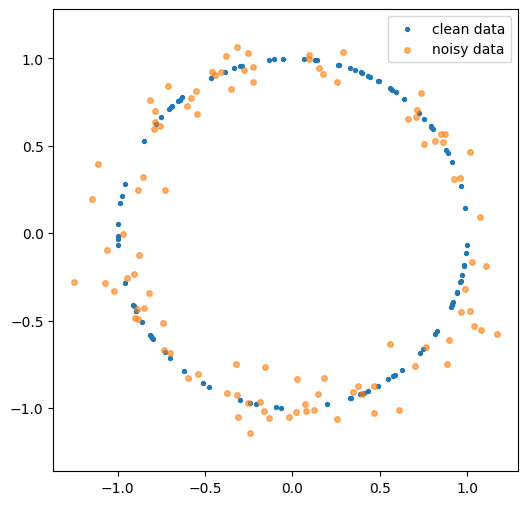

In [2]:
import tadasets
np.random.seed(565656)

data_clean = tadasets.dsphere(d=1, n=100, noise=0.0)
data_noisy = tadasets.dsphere(d=1, n=100, noise=0.10)

# data_clean = tadasets.infty_sign(n=100, noise=0.0)
# data_noisy = tadasets.infty_sign(n=100, noise=0.15)

plt.rcParams["figure.figsize"] = (6, 6)
plt.scatter(data_clean[:,0], data_clean[:,1], label="clean data", s=8)
plt.scatter(data_noisy[:,0], data_noisy[:,1], label="noisy data", s=16, alpha=0.6)
plt.axis('equal')
plt.legend()
plt.show()

In [3]:
import ripser
import persim

def diagram_sizes(dgms):
    return ", ".join([f"|$H_{i}$|={len(d)}" for i, d in enumerate(dgms)])

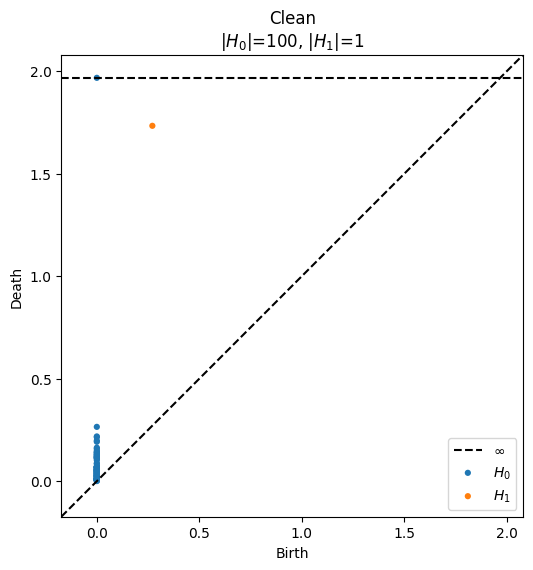

In [4]:
dgm_clean = ripser.ripser(data_clean)['dgms']
persim.plot_diagrams(
    dgm_clean,
    show=True,
    title=f"Clean\n{diagram_sizes(dgm_clean)}"
)

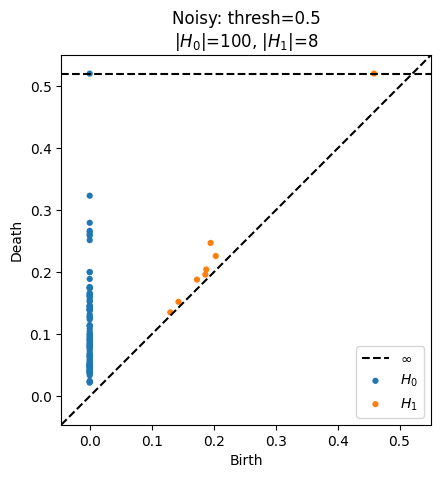

In [5]:
thresh = 0.5
dgm_noisy = ripser.ripser(data_noisy, thresh=thresh)['dgms']
persim.plot_diagrams(
    dgm_noisy, show=True,
    title=f"Noisy: thresh={thresh}\n{diagram_sizes(dgm_noisy)}"
)

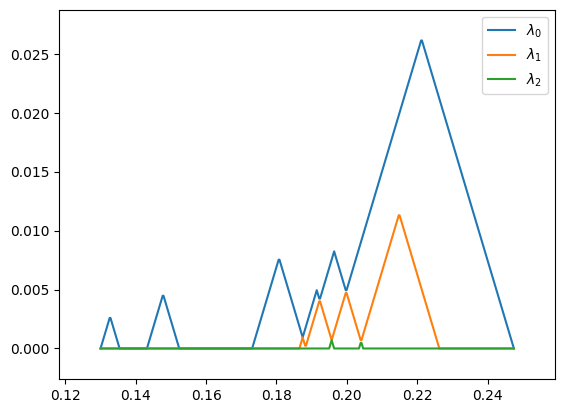

In [8]:
from persim import PersLandscapeApprox, PersLandscapeExact
from persim.landscapes import plot_landscape_simple

pla = PersLandscapeApprox(dgms=dgm_noisy,hom_deg=1)
ax = plot_landscape_simple(pla, depth_range=range(10))